# Previsão de notas dos alunos
Muitos alunos de pós-graduação têm dificuldade em obter boas notas porque não recebem muito apoio nos cursos superiores em comparação com o apoio que os alunos recebem nas escolas. Alguns alunos precisam de muita atenção dos instrutores para que obtenham boas notas, sem isso, o estado emocional do aluno pode ser prejudicial para a sua carreira a longo prazo.

**O objetivo desse projeto é, através do aprendizado de máquina, prever as notas dos alunos para que os instrutores possam ajudar os alunos a se prepararem para tópicos em que as notas dos alunos foram previstas baixas.**  



https://www.kaggle.com/code/ramontanoeiro/student-performance/notebook

# #5 - Resultados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Algoritmos escolhido ao fim da avaliação dos algoritmos
from sklearn.svm import SVR

import pandas as pd
import numpy as np
import math
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
path_datasets = '/content/drive/MyDrive/Machine Learning e Data Science com Python/Projeto - Nota dos Alunos/'

## Carregando datasets

In [3]:
with open(path_datasets+'students_data_2.pkl', 'rb') as f:
  [X_train, X_MA_train, X_MMA_train,
   X_test , X_MA_test , X_MMA_test ,

   X_forest_train, X_forest_test,
   X_xgbr_train, X_xgbr_test,
   X_tree_train, X_tree_test,
   X_svm_lin_train, X_svm_lin_test,
   
   y_train, y_test] = pkl.load(f)

In [4]:
print('Base de dados para usar o algoritmo SVM Linear')
print(X_svm_lin_train.shape, X_svm_lin_test.shape)
print('Target')
print(y_train.shape, y_test.shape)

Base de dados para usar o algoritmo SVM Linear
(296, 1) (99, 1)
Target
(296,) (99,)


## Testando os modelo SVM Linear

In [5]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

model = SVR(C = 1.2, gamma = 'auto', kernel = 'linear', tol = 0.0001)
model.fit(X_svm_lin_train, y_train)

y_pred = model.predict(X_svm_lin_test)

## Resultados

In [6]:
MAE  = mean_absolute_error(y_test, y_pred)
MSE  = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

In [7]:
print(f'Em média, o algoritmo erra a nota dos alunos em {round(MAE, 2)} pontos')
print(f'MSE: {round(MSE, 2)} | RMSE: {round(RMSE, 2)}')

Em média, o algoritmo erra a nota dos alunos em 1.21 pontos
MSE: 5.89 | RMSE: 2.43


In [8]:
data = []
for t, p in zip(y_test.array, y_pred):
  data.append( (int(t), int(p)) )

df = pd.DataFrame(data, columns = ('Test', 'Pred'))
df.head()

,Test,Pred
0,0,10
1,7,6
2,9,6
3,6,4
4,12,12


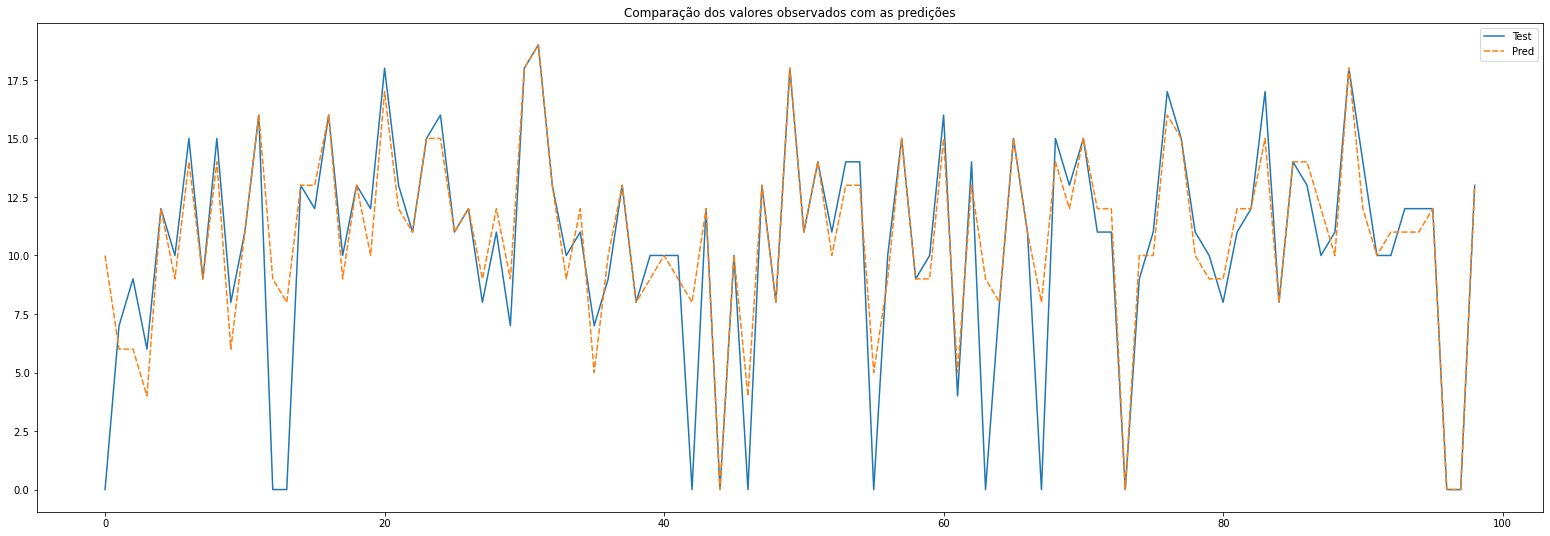

In [9]:
plt.figure(figsize = (27, 9))
plt.title('Comparação dos valores observados com as predições')
sns.lineplot(data=df);

In [10]:
def get_cm(df, confusion_matrix):
  TP = df[ df[confusion_matrix] == 'TP'].count()[0]
  FP = df[ df[confusion_matrix] == 'FP'].count()[0]
  TN = df[ df[confusion_matrix] == 'TN'].count()[0]
  FN = df[ df[confusion_matrix] == 'FN'].count()[0]
  return TP, FP, TN, FN

**Considerando que o aluno precisa de ao menos 14 pontos (70% da nota) para ser aprovado no G3**

- **TP**: modelo indica que o aluno pontuará < 14pts e o aluno pontua < 14pts **(objetivo)**
- **FP**: modelo indica que o aluno pontuará < 14pts e o aluno pontua >= 14pts
- **TN**: modelo indica que o aluno pontuará >= 14pts e o aluno pontua >= 14pts
- **FN**: modelo indica que o aluno pontuará >= 14pts e o aluno pontua < 14pts **(evitar)**

In [11]:
confusion_matrix = []
for t, p in df.values:
  confusion_matrix.append( 'TP' if (p < 14 and t < 14) else 'FP' if (p < 14 and t >= 14) else 'TN' if (p >= 14 and t >= 14) else 'FN' if (p >= 14 and t < 14) else None) 
df['CM1'] = confusion_matrix
df.head(15)

,Test,Pred,CM1
0,0,10,TP
1,7,6,TP
2,9,6,TP
3,6,4,TP
4,12,12,TP
5,10,9,TP
6,15,14,TN
7,9,9,TP
8,15,14,TN
9,8,6,TP


In [12]:
TP, FP, TN, FN = get_cm(df, 'CM1')
TP, FP, TN, FN

(73, 4, 21, 1)

In [13]:
precision = round( (TP/(TP+FP))*100, 2 )
recall    = round( (TP/(TP+FN))*100, 2 )

In [14]:
print(f'Quando o modelo previu que o aluno pontuaria uma nota baixa, ele estava correto em {precision}%')
print(f'Quando o aluno pontuou nota baixa, o modelo conseguiu prever {recall}% dos casos')

Quando o modelo previu que o aluno pontuaria uma nota baixa, ele estava correto em 94.81%
Quando o aluno pontuou nota baixa, o modelo conseguiu prever 98.65% dos casos


## Resultado dos alunos que pontuaram <=30% (6 pontos)

- **TP**: modelo indica que o aluno pontuará <= 6pts e o aluno pontua <= 6pts **(objetivo)**
- **FP**: modelo indica que o aluno pontuará <= 6pts e o aluno pontua > 6pts
- **TN**: modelo indica que o aluno pontuará > 6pts e o aluno pontua > 6pts
- **FN**: modelo indica que o aluno pontuará > 6pts e o aluno pontua <= 6pts **(evitar)**

In [16]:
confusion_matrix = []
for t, p in df[['Test', 'Pred']].values:
  confusion_matrix.append( 'TP' if (p <= 6 and t <= 6) else 'FP' if (p <= 6 and t > 6) else 'TN' if (p > 6 and t > 6) else 'FN' if (p > 6 and t <= 6) else None) 
df['CM2'] = confusion_matrix
df.head(15)

,Test,Pred,CM1,CM2
0,0,10,TP,FN
1,7,6,TP,FP
2,9,6,TP,FP
3,6,4,TP,TP
4,12,12,TP,TN
5,10,9,TP,TN
6,15,14,TN,TN
7,9,9,TP,TN
8,15,14,TN,TN
9,8,6,TP,FP


In [17]:
TP, FP, TN, FN = get_cm(df[ df['Test'] <= 6 ], 'CM2')
TP, FP, TN, FN

(8, 0, 0, 6)

In [18]:
precision = round( (TP/(TP+FP))*100, 2 )
recall    = round( (TP/(TP+FN))*100, 2 )

In [20]:
print(f'Quando o modelo previu que o aluno pontuaria uma nota muito baixa (<=6), ele estava correto em {precision}%')
print(f'Quando o aluno pontuou nota muito baixa (<=6), o modelo conseguiu prever {recall}% dos casos')

Quando o modelo previu que o aluno pontuaria uma nota muito baixa (<=6), ele estava correto em 100.0%
Quando o aluno pontuou nota muito baixa (<=6), o modelo conseguiu prever 57.14% dos casos
